In [1]:
import matlab.engine
import numpy as np
eng = matlab.engine.start_matlab()

In [2]:
ret = eng.triarea(2.0,6.0)
print(ret)

6.0


In [3]:
# ---Initial parameters---
rrLength = 50       # A desired ECG signal length (the number of RR intervals) 
APBrate = 0.10      # Rate of atrial premature beats (APB). A number between 0 and 0.5
onlyRR = 0          # 1 - only RR intervals are generated, 0 - multilead ECG is generated

medEpis = 15        # Median duration of an atrial fibrillation (AF) episode
stayInAF = float(1-np.log(2)/medEpis)   # Probability to stay in AF state
AFburden = 0.8      # AF burden. 0 - the entire signal is sinus rhythm (SR), 1 - the entire signal is AF

noiseType = 0       # Type of noise. A number from 0 to 4. 0 - no noise added (noise RMS = 0 mV), 
                    # 1 - motion artefacts, 2 - electrode movement artefacts, 3 - baseline wander, 
                    # 4 - mixture of type 1, type 2 and type 3 noises
noiseRMS = 0.02     # Noise level in milivolts 

realRRon = 1       # 1 - real RR series are used, 0 - synthetic
realVAon = 1       # 1 - real ventricular activity is used, 0 - synthetic
realAAon = 1       # 1 - real atrial activity is used, 0 - synthetic
# Note: cannot select real atrial activity and synthetic ventricular activity

In [4]:
signal_generator_path = eng.genpath('C:/Users/flori\OneDrive\Dokumente\TU\Bachelor Thesis\Code\Signal_generator')
eng.addpath(signal_generator_path, nargout=0)

#[simPAFdata, initialParameters] = eng.simPAF_ECG_generator(rrLength, realRRon, realVAon, realAAon, AFburden, stayInAF, APBrate, noiseType, noiseRMS, onlyRR)
returndata = eng.simPAF_ECG_generator(rrLength, realRRon, realVAon, realAAon, AFburden, stayInAF, APBrate, noiseType, noiseRMS, onlyRR)

In [5]:
len(returndata['multileadECG'])

15

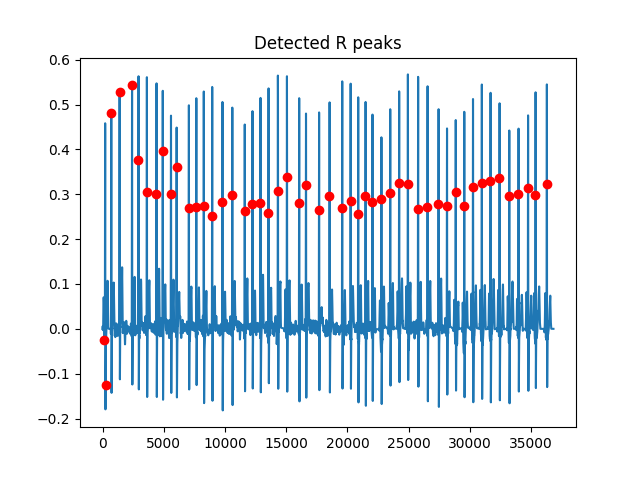

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from ecgdetectors import Detectors
import sys


unfiltered_ecg_dat = np.transpose(np.array(returndata['multileadECG']))
unfiltered_ecg = unfiltered_ecg_dat[:, 0]
fs = 500

detectors = Detectors(fs)

# selected detector by the user (default is the two average one)
seldet = 4

if seldet < 0:
    # default detector
    r_peaks = detectors.two_average_detector(unfiltered_ecg)
else:
    # We use the input argument to select a detector
    r_peaks = detectors.get_detector_list()[seldet][1](unfiltered_ecg)

# If you want to always use the same det then directly call it:
#r_peaks = detectors.two_average_detector(unfiltered_ecg)
#r_peaks = detectors.matched_filter_detector(unfiltered_ecg,"templates/template_250hz.csv")
#r_peaks = detectors.swt_detector(unfiltered_ecg)
#r_peaks = detectors.engzee_detector(unfiltered_ecg)
#r_peaks = detectors.christov_detector(unfiltered_ecg)
#r_peaks = detectors.hamilton_detector(unfiltered_ecg)
#r_peaks = detectors.pan_tompkins_detector(unfiltered_ecg)
#r_peaks = detectors.wqrs_detector(unfiltered_ecg)

#%matplotlib widget
plt.figure()
plt.plot(unfiltered_ecg)
plt.plot(r_peaks, unfiltered_ecg[r_peaks], 'ro')
plt.title("Detected R peaks")

plt.show()

In [46]:
actual = np.transpose(np.array(returndata['rr']))[:,0]
predicted = np.diff(np.array(r_peaks))#/fs*1000)

In [47]:
from sklearn.metrics import f1_score

f1_score(actual, predicted,average='weighted')

0.026666666666666665